<a href="https://colab.research.google.com/github/KaruDevs/ANALISIS-DE-PREFERENCIAS-MUSICALES-A-NIVEL-GLOBAL/blob/main/ConsolidadoM7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Vista general del dataset:
     País  Pop  Rock  Hip-Hop  Electrónica  Clásica  Jazz  Reguetón  Metal
0   Chile   71    22       79           61       70    58        79     69
1    EEUU   34    41       40           79       74    37        90     23
2  México   91    72       52           99       83    23        63     21
3   Corea   80    21       95           34       22    79        27     25
4   Japón   40    49       77           81       70    33        66     73


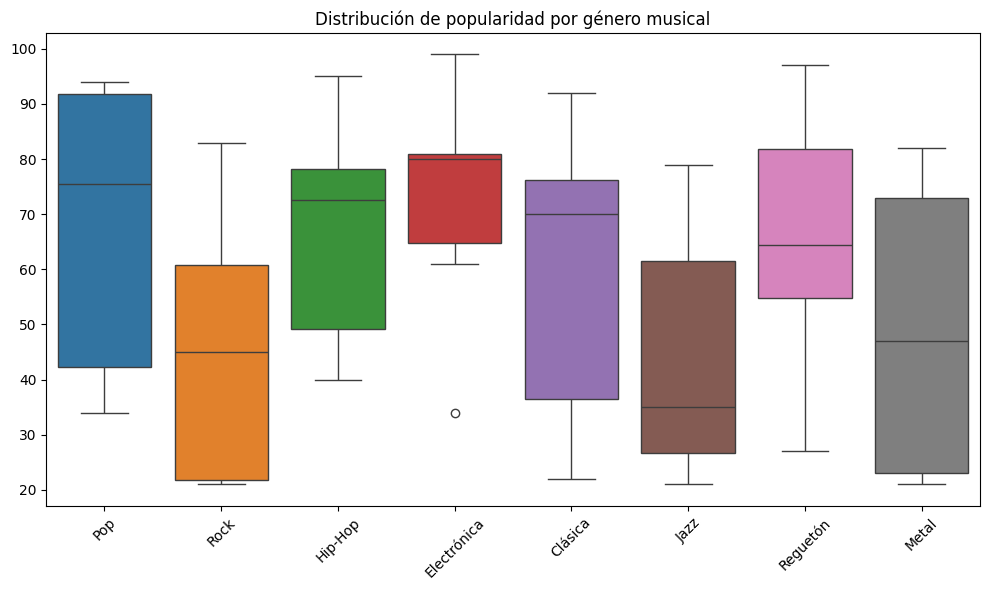

Etiquetas K=3: [2 1 0 2 1 0 2 1]


ValueError: n_samples=8 should be >= n_clusters=9.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. Carga y exploración de datos
df = pd.read_csv("dataset_generos_musicales.csv")
print(" Vista general del dataset:")
print(df.head())

# Separar nombres de países y normalizar datos
paises = df['País']
X = df.drop('País', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Distribuciones iniciales
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.title("Distribución de popularidad por género musical")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Clusterización

# K-Means con K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_k3 = kmeans.fit_predict(X_scaled)
print("Etiquetas K=3:", labels_k3)

# Método del codo
inertia = []
K_range = range(1, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(K_range, inertia, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.show()

# Coeficiente de silueta
sil_scores = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    score = silhouette_score(X_scaled, km.labels_)
    sil_scores.append(score)

plt.figure()
plt.plot(range(2, 9), sil_scores, marker='o')
plt.title("Coeficiente de silueta")
plt.xlabel("Número de clusters")
plt.ylabel("Silueta")
plt.show()

# Clustering jerárquico
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=paises.values, orientation='top')
plt.title("Dendrograma - Clustering jerárquico")
plt.tight_layout()
plt.show()

# Determinar clusters jerárquicos
labels_hier = fcluster(linked, t=3, criterion='maxclust')
print("Etiquetas jerárquicas:", labels_hier)

# DBSCAN
eps_values = [1.5, 2.0, 2.5]
min_samples = [2, 3]

for eps in eps_values:
    for min_pts in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_pts)
        labels_db = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        print(f"DBSCAN eps={eps}, minPts={min_pts} → clusters: {n_clusters}")

# 3. Reducción de dimensionalidad

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(explained_var >= 0.90) + 1
print(f"Componentes necesarios para 90% varianza: {n_components_90}")

# Visualización PCA 2D
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1])
for i, pais in enumerate(paises):
    plt.text(X_pca[i, 0], X_pca[i, 1], pais)
plt.title("PCA - Primeras dos componentes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# t-SNE
for perplexity in [5, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    plt.figure()
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    for i, pais in enumerate(paises):
        plt.text(X_tsne[i, 0], X_tsne[i, 1], pais)
    plt.title(f"t-SNE (perplexity={perplexity})")
    plt.grid(True)
    plt.show()

# 4. Conclusiones (para incluir en documento aparte)
"""
Comparación de métodos:
- K-Means es eficiente y fácil de interpretar, pero depende de K.
- Clustering jerárquico ofrece una visión estructural clara (dendrograma).
- DBSCAN detecta agrupaciones no convexas, pero es sensible a parámetros.

Visualización:
- PCA permite interpretar componentes, útil para análisis explicativo.
- t-SNE es más expresivo visualmente, ideal para relaciones no lineales.

Interpretación:
- Los clusters reflejan similitudes culturales (ej. reguetón en LATAM, electrónica en Europa).
- Se observan patrones que coinciden con tendencias globales de consumo musical.
"""